# Setup

In [1]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/My\ Drive/CLIPProj

Mounted at /content/drive
/content/drive/My Drive/CLIPProj


In [2]:
# Install dependencies
# !pip freeze | grep tqdm  # check existing libraries
!pip install -r requirements.txt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 818.9/818.9 kB 20.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 89.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 68.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 51.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 75.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 961.5/961.5 kB 52.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [3]:
# Library Imports
import os
from dotenv import load_dotenv

import numpy as np
import matplotlib.pyplot as plt

import torch
from torch.utils.data import DataLoader, Dataset, random_split
# import torch_xla.core.xla_model as xm
# import torch_xla.distributed.xla_multiprocessing as xmp

import torchvision
from torchvision import transforms

import lightning as L
from lightning.pytorch.callbacks import ModelCheckpoint, EarlyStopping
from tqdm import tqdm

from transformers import CLIPProcessor, CLIPVisionModel

In [4]:
# General Setup
RAND_SEED = 42
load_dotenv()
L.seed_everything(RAND_SEED)

# Use Colab GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

INFO: Seed set to 42
INFO:lightning.fabric.utilities.seed:Seed set to 42


cuda


# Data

## Downloading Data

In [5]:
class ColorFix(object):
    def __call__(self, img):
        if img.mode == 'L':
            img = img.convert("RGB")
        return img

transform = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        ColorFix(),
        transforms.ToTensor(),
    ]
)

In [58]:
# Caltech 101 Data
data = torchvision.datasets.Caltech101('data', transform=transform, download=True)
cat_labels = data.annotation_categories

## CLIP Embeddings

In [7]:
clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
clip_model = CLIPVisionModel.from_pretrained("openai/clip-vit-base-patch32").to(device)

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/862k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

In [8]:
dataloader = DataLoader(data, batch_size=64, shuffle=False, num_workers=2, drop_last=True)
embeddings = []
labels = []
images = []

for imgs, labs in tqdm(dataloader):
    inputs = clip_processor(images=imgs, return_tensors="pt", padding=True, do_rescale=False).to(device)
    with torch.no_grad():
        outputs = clip_model(**inputs).pooler_output
        # curr = outputs.cpu()
    embeddings.append(outputs)
    labels.append(labs)
    images.append(imgs)

embeddings = torch.cat(embeddings)
labels = torch.cat(labels)
images = torch.cat(images)


100%|██████████| 135/135 [24:54<00:00, 11.07s/it]


In [9]:
# Custom Dataset to Hold Embeddings
class EmbeddingData(Dataset):
    def __init__(self, embeddings, labels, images):
        self.embeddings = embeddings
        self.labels = labels
        self.images = images

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, i):
        return self.embeddings[i], self.labels[i], self.images[i]

In [10]:
data = EmbeddingData(embeddings, labels, images)

In [11]:
torch.save(data, 'clip-data.pt')

## Splitting Data

In [61]:
torch.serialization.add_safe_globals([EmbeddingData])
# data = torch.load('clip-data.pt')
data = torch.load('clip-data.pt', map_location=device)

In [62]:
TRAIN_RATIO, VAL_RATIO = 0.7, 0.15

data_n = len(data)
train_n = int(TRAIN_RATIO * data_n)
val_n = int(VAL_RATIO * data_n)
test_n = data_n - train_n - val_n

In [63]:
train_data, val_data, test_data = random_split(
    data, [train_n, val_n, test_n], generator=torch.Generator().manual_seed(RAND_SEED)
)

In [64]:
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = DataLoader(val_data, batch_size=64)
test_loader = DataLoader(test_data, batch_size=64)

# Modeling

## Creating Model

In [65]:
# Model Definition
class CLIPClassifier(L.LightningModule):
  def __init__(self, input_dim=768, hidden_dim=512, output_dim=101, lr=1e-3):
    super().__init__()
    self.lr = lr

    # Model Architecture
    self.model = torch.nn.Sequential(
        torch.nn.Linear(input_dim, hidden_dim),
        torch.nn.ReLU(),
        torch.nn.Dropout(0.2),
        torch.nn.Linear(hidden_dim, hidden_dim // 2),
        torch.nn.ReLU(),
        torch.nn.Dropout(0.2),
        torch.nn.Linear(hidden_dim // 2, output_dim)
    ).to(device)

    self.loss_fn = torch.nn.CrossEntropyLoss()

  def forward(self, x):
    return self.model(x)

  def _step(self, batch, stage):
      x, y, _ = batch
      logits = self.forward(x)
      loss = self.loss_fn(logits, y)

      preds = torch.argmax(logits, dim=1)
      acc = (preds == y).float().mean()

      self.log(f'{stage}_loss', loss, prog_bar=True)
      self.log(f'{stage}_acc', acc, prog_bar=True)

      return loss

  def training_step(self, batch, batch_idx):
      return self._step(batch, "train")

  def validation_step(self, batch, batch_idx):
      return self._step(batch, "val")

  def test_step(self, batch, batch_idx):
      return self._step(batch, "test")

  def configure_optimizers(self):
      optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
      scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
          optimizer, mode="min", factor=0.5, patience=2
      )
      return {
          "optimizer": optimizer,
          "lr_scheduler": {
              "scheduler": scheduler,
              "monitor": "val_loss",
              "interval": "epoch",
              "frequency": 1,
          },
      }

In [66]:
# Callbacks
checkpoint_callback = ModelCheckpoint(
    monitor="val_loss",
    dirpath="./checkpoints/",
    filename="clip-classifier-{epoch:02d}-{val_loss:.2f}",
    save_top_k=3,
    mode="min",
)

early_stop_callback = EarlyStopping(monitor="val_loss", patience=5, mode="min")

In [67]:
classifier = CLIPClassifier()

## Train Model

In [68]:
from lightning.pytorch.loggers import WandbLogger
import wandb

wandb.login(key=os.environ.get("WANDB_API_KEY"))

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


True

In [69]:
wandb_logger = WandbLogger(project="clip-classifier", name="clip-classifier", log_model=True)
trainer = L.Trainer(
    max_epochs=10,
    accelerator='auto',
    logger=wandb_logger,
    callbacks=[checkpoint_callback, early_stop_callback],
)

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [70]:
trainer.fit(classifier, train_loader, val_loader)

/usr/local/lib/python3.11/dist-packages/lightning/pytorch/loggers/wandb.py:397: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/callbacks/model_checkpoint.py:654: Checkpoint directory /content/drive/MyDrive/CLIPProj/checkpoints exists and is not empty.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name    | Type             | Params | Mode 
-----------------------------------------------------
0 | model   | Sequential       | 551 K  | train
1 | loss_fn | CrossEntropyLoss | 0      | train
-----------------------------------------------------
551 K     Trainable params
0         Non-trainable params
551 K     Total params
2.204     Total estimated model params size (MB)
9         Modules in train m

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=10` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


## Test

In [71]:
trainer.test(classifier, test_loader)

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │     0.957561731338501     │
│         test_loss         │    0.1565234512090683     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.1565234512090683, 'test_acc': 0.957561731338501}]

In [72]:
def example_preds(model, dataset, indices=None):
    if indices is None:
        indices = np.random.choice(len(dataset), 5)

    model.eval()
    model.to(device)
    fig, axs = plt.subplots(1, len(indices), figsize=(15, 3))

    for i, idx in enumerate(indices):
        embedding, label, image = dataset[idx]
        embedding = embedding.to(device)

        with torch.no_grad():
            logits = model(embedding.unsqueeze(0))
            pred = torch.argmax(logits, dim=1).item()

        if isinstance(image, torch.Tensor):
            img_np = image.permute(1, 2, 0).detach().cpu().numpy() if image.ndim == 3 else image.squeeze().detach().cpu().numpy()
        else:
            img_np = image

        axs[i].imshow(img_np, cmap='gray' if img_np.ndim == 2 else None)
        axs[i].set_title(f"True: {cat_labels[label]}\nPred: {cat_labels[pred]}")
        axs[i].axis("off")

    plt.tight_layout()
    plt.show()

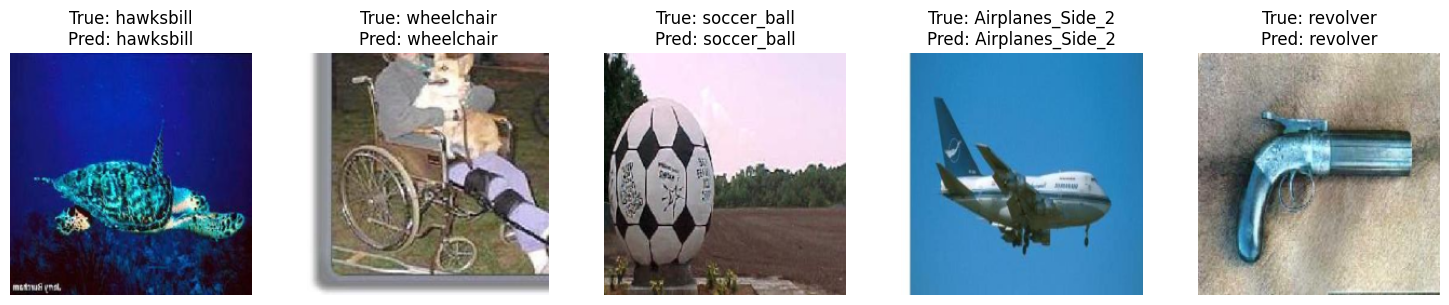

In [73]:
example_preds(classifier, data)

In [74]:
wandb.finish()

epoch,▂▂▃▃▃▃▃▄▅▅▆▇▇██▃▄▄▆▇▁▂▂▃▄▆▇▇██▁▃▃▃▄▆▆▆▆▇
test_acc,█▆▄▁
test_loss,▁▂▂█
train_acc,▂▆▇█▇█▇▇██▁▇▇█▇█████▇▇█▇▇███▇▄█▇▇▇██▇██▇
train_loss,█▂▁▁▁▁▁▁▁▁▂▃▂▁▂▁▁▁▁▁▁▃▂▂▁▁▁▁▂▁▃▁▂▁▂▁▂▁▁▁
trainer/global_step,▂▄▄▅▆▇█▁▁▂▂▃▃▄▄▅▅▆▇▇█▁▁▁▃▄▄▄▄▅▆▆▇█▁▂▃▄▅█
val_acc,▁▇▇▇▇▇▇▇▇█▁▆▆▇▇▆██▇█▃▅▇▇▇▇▇▇▇▇▂▅▇▆▆▆██▇█
val_loss,▇▂▁▁▂▁▂▂▁▁█▃▂▂▂▂▁▃▁▁▆▃▁▂▂▁▂▁▂▂▇▃▂▂▂▁▁▁▂▁
epoch,10
test_acc,0.95756
test_loss,0.15652
